In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia')

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:25<00:00, 97.0MB/s]


### Data Visualization

In [ ]:
from torchvision import transforms as tt

# Define the transformations to be applied to the images
transforms = tt.Compose([
    tt.Resize((224, 224)),
    tt.ToTensor()
])

In [ ]:
from torchvision.datasets import ImageFolder

data_path = '/content/chest-xray-pneumonia/chest_xray/train'
dataset = ImageFolder(data_path, transform=transforms)

In [ ]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

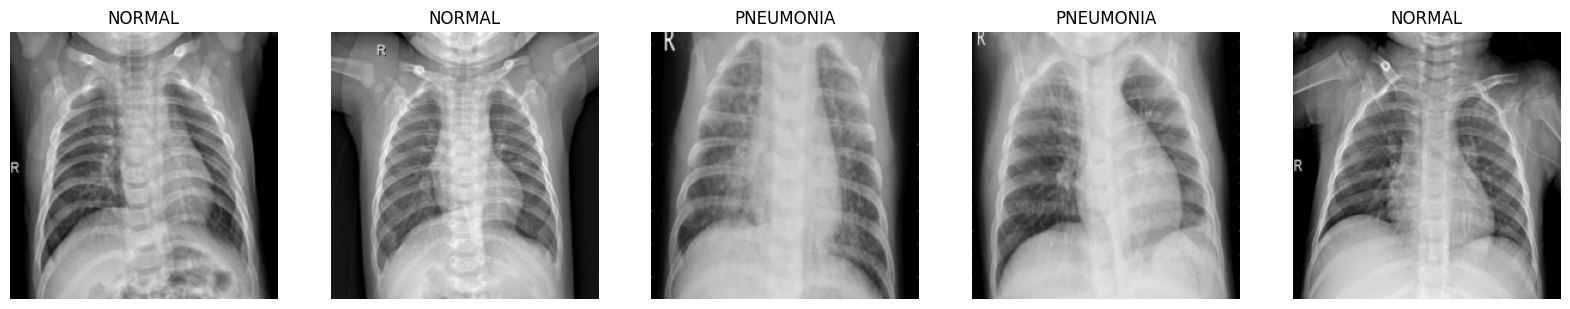

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display images
def show_images(images, labels, num_images=50):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        # Move the channel dimension to the last dimension using np.transpose
        axes[i].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.show()

# Get some sample images and labels from the dataset
num_images_to_display = 5
sample_indices = np.random.choice(len(dataset), num_images_to_display, replace=False)
sample_images = [dataset[i][0] for i in sample_indices]
sample_labels = [dataset.classes[dataset[i][1]] for i in sample_indices]

# Display the sample images with their labels
show_images(sample_images, sample_labels, num_images=num_images_to_display)

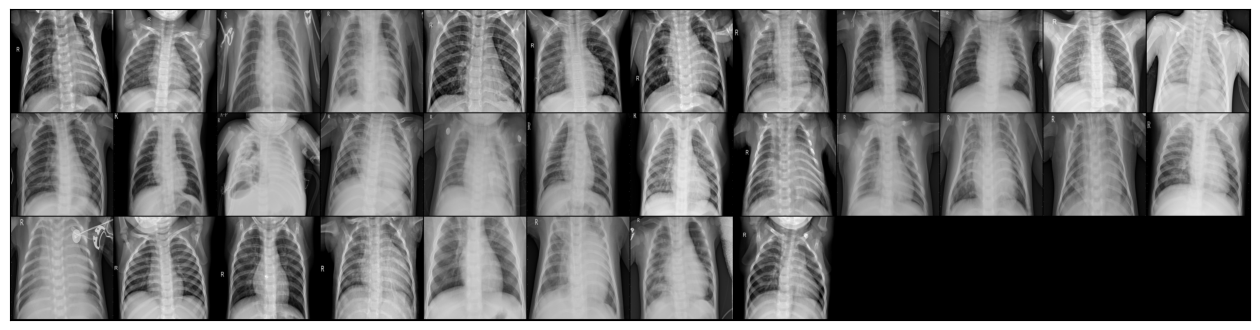

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=12).permute(1, 2, 0))
        break

show_batch(data_loader)

### Data Preparation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
# Set up data directories
data_dir = '/content/chest-xray-pneumonia/chest_xray'  # Path where train, val, and test folders are located

# Class names for the binary classification problem
class_names = ['Normal', 'Pneumonia']

# Image transformations for Vision Transformer
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (ViT input size)
    transforms.ToTensor(),          # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### ViT Training

In [ ]:
# Load pre-trained Vision Transformer model
model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

# Modify the final classification layer to match the number of classes (2)
model.heads.head = nn.Linear(in_features=model.heads.head.in_features, out_features=2) # model.heads is the classification head

# Move the model to the appropriate device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            running_loss += loss.item()

        train_acc = correct_train / total_train

        # Validation phase
        model.eval()  # Set model to evaluation mode
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = correct_val / total_val

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, "
              f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model_vit_chest_xray.pth')

    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

In [ ]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 29.2452, Train Accuracy: 0.9266, Validation Accuracy: 0.8750
Epoch [2/10], Loss: 8.7181, Train Accuracy: 0.9808, Validation Accuracy: 0.6875
Epoch [3/10], Loss: 5.9024, Train Accuracy: 0.9868, Validation Accuracy: 0.7500
Epoch [4/10], Loss: 6.2243, Train Accuracy: 0.9852, Validation Accuracy: 0.8750
Epoch [5/10], Loss: 4.4886, Train Accuracy: 0.9900, Validation Accuracy: 0.9375
Epoch [6/10], Loss: 5.9542, Train Accuracy: 0.9854, Validation Accuracy: 0.8750
Epoch [7/10], Loss: 3.8971, Train Accuracy: 0.9921, Validation Accuracy: 0.9375
Epoch [8/10], Loss: 3.6926, Train Accuracy: 0.9910, Validation Accuracy: 0.9375
Epoch [9/10], Loss: 2.0401, Train Accuracy: 0.9950, Validation Accuracy: 0.8750
Epoch [10/10], Loss: 2.2608, Train Accuracy: 0.9952, Validation Accuracy: 0.9375
Best Validation Accuracy: 0.9375


In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

# Load the best model
model.load_state_dict(torch.load('best_model_vit_chest_xray.pth'))

<ipython-input-18-108c6c37d4dc>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_vit_chest_xray.pth'))


<All keys matched successfully>

In [ ]:
# Test the model
test_model(model, test_loader)

Test Accuracy: 0.8814


In [ ]:
def predict_image(model, image_path, class_names):
    model.eval()

    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        return class_names[predicted.item()]

# Example usage
image_path = '/content/download.jpeg'
predicted_class = predict_image(model, image_path, class_names)
print(f"Predicted Class: {predicted_class}")

Predicted Class: Normal


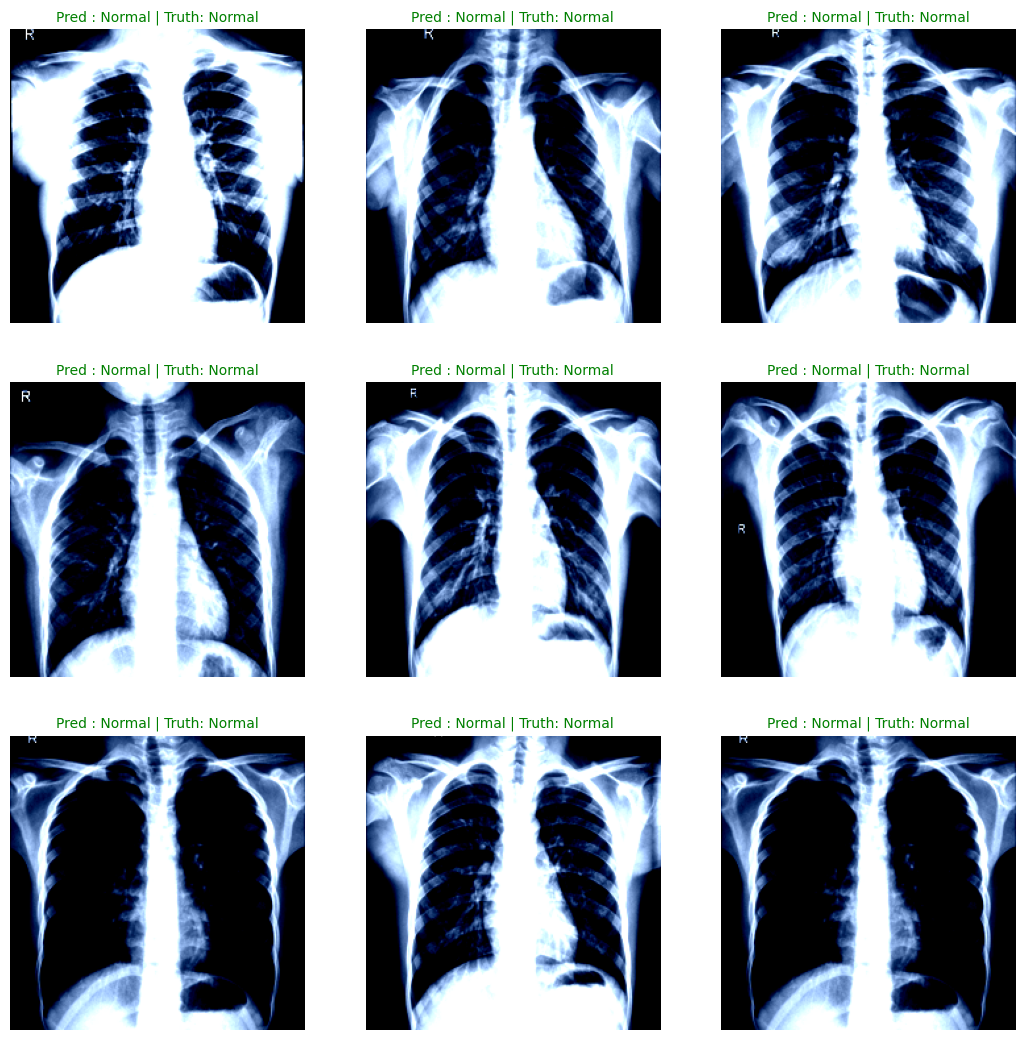

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Get a batch of images from the train_loader
images, labels = next(iter(test_loader))
with torch.no_grad():
  predicted_labels = model(images.to(device))
  predicted_labels = torch.argmax(predicted_labels, 1)
rows = col = 3
#fig, axes = plt.subplots(nrows=5, ncols=5)
plt.figure(figsize = (13,13))
images = images.cpu()
for i in range(rows*col):
  # Plot a random image from the batch
  random_index = np.random.randint(0, images.shape[0])
  image = images[random_index]
  label = labels[random_index]
  pred_label = predicted_labels[random_index]
  plt.subplot(rows, col, i+1)
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))
  # plt.title(f'Label: {test_ds.classes[label]}, Pred: {test_ds.classes[pred_label]}')
  title_text = f"Pred : {class_names[pred_label]} | Truth: {class_names[label]}"
  if pred_label == label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")
  plt.axis(False)

### Swin Transformer

In [ ]:
!pip install timm

In [ ]:
import timm
import torch.nn as nn

# Load a pre-trained Swin Transformer model
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

# Modify the classifier head to match the number of classes (4 classes in our case)
model.head = nn.Linear(model.head.in_features, 2)

# Move the model to the appropriate device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the available device (GPU or CPU)
model = model.to(device)

# Print model summary
print(model)


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass: compute outputs
            outputs = model(images)

            # If the output has extra dimensions, remove them using .squeeze()
            if len(outputs.shape) > 2:  # Output shape should be [batch_size, num_classes]
                outputs = outputs.view(outputs.size(0), -1)  # Flatten the output

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track the loss
            running_loss += loss.item()

            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        accuracy = 100. * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # Validation (if you have a validation loop)
        validate(model, val_loader, criterion)

def validate(model, val_loader, criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Flatten output if it has extra dimensions
            if len(outputs.shape) > 2:
                outputs = outputs.view(outputs.size(0), -1)

            # Compute validation loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100. * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")


In [ ]:
# Testing function
def test(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    # Disable gradient calculation for inference
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass: get model outputs
            outputs = model(images)

            # If the output has extra dimensions, remove them using .squeeze()
            outputs = outputs.squeeze()  # Remove any extra dimensions

            # Ensure the output is in shape [batch_size, num_classes]
            if len(outputs.shape) > 2:  # If there are still extra dimensions
                outputs = outputs.view(outputs.size(0), -1)  # Flatten the output

            # Outputs will be logits; we need the predicted class
            _, predicted = torch.max(outputs, 1)  # Take the maximum logit along the class dimension

            # Ensure correct shape between predictions and labels
            total += labels.size(0)  # Total number of labels

            # Compare predicted classes to ground truth labels
            correct += (predicted == labels).sum().item()  # Count correct predictions

    # Calculate accuracy
    accuracy = 100. * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Run the testing phase
test(model, test_loader)

Test Accuracy: 0.16%


In [ ]:
# Train the model for 10 epochs (or as needed)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=11)

print()

# Evaluate on the test dataset
test(model, test_loader)

Epoch [1/11], Loss: 0.3880, Accuracy: 88.23%
Validation Loss: 0.1360, Validation Accuracy: 93.75%
Epoch [2/11], Loss: 0.0663, Accuracy: 97.72%
Validation Loss: 0.0522, Validation Accuracy: 100.00%
Epoch [3/11], Loss: 0.0385, Accuracy: 98.50%
Validation Loss: 0.0277, Validation Accuracy: 100.00%
Epoch [4/11], Loss: 0.0310, Accuracy: 98.93%
Validation Loss: 0.0383, Validation Accuracy: 100.00%
Epoch [5/11], Loss: 0.0119, Accuracy: 99.52%
Validation Loss: 0.0184, Validation Accuracy: 100.00%
Epoch [6/11], Loss: 0.0212, Accuracy: 99.29%
Validation Loss: 0.3152, Validation Accuracy: 87.50%
Epoch [7/11], Loss: 0.0243, Accuracy: 99.08%
Validation Loss: 0.4480, Validation Accuracy: 75.00%
Epoch [8/11], Loss: 0.0068, Accuracy: 99.79%
Validation Loss: 0.9114, Validation Accuracy: 81.25%
Epoch [9/11], Loss: 0.0105, Accuracy: 99.62%
Validation Loss: 0.0002, Validation Accuracy: 100.00%
Epoch [10/11], Loss: 0.0130, Accuracy: 99.52%
Validation Loss: 0.0229, Validation Accuracy: 100.00%
Epoch [11/11]

### Saving

In [ ]:
# copy model to drive
!cp /content/best_model_vit_chest_xray.pth /content/drive/MyDrive/